\begin{eqnarray}
& \max_{x_t} & \mathbb{E}[c_t^\top x_t] \\
& s.t. & A_0 x_0 \leq d_0 \\
& & A_t x_t + B_t x_{t-1} \leq d_t, \quad t=1,\dots,T, \quad \text{with} \quad d_t \sim \text{Unif}(1, 10), \quad d_1,\dots,d_T \ \text{i.i.d.} \\
& & x_t \geq 0, \quad t=0,\dots,T
\end{eqnarray}

In [2]:
from stochoptim.stochprob.stochastic_problem_basis import StochasticProblemBasis

class MyMultistageStochasticProblem(StochasticProblemBasis):
    
    def __init__(self, T, A, B, c, d0):
        
        self.T = T         # last stage
        self.A = A         # A = {t: A[t] for t=0,...,T} where A[t] is a 2d-array
        self.B = B         # B = {t: B[t] for t=1,...,T} where B[t] is a 2d-array
        self.c = c         # c = {t: c[t] for t=0,...,T} where c[t] is a 1d-array
        self.d0 = d0       # 1d-array
        self.n = {t: A[t].shape[1] for t in range(self.T + 1)} # number of variables per stage
        self.m = {t: A[t].shape[0] for t in range(self.T + 1)} # number of constraints per stage
      
        StochasticProblemBasis.__init__(self, 
                                        name='Simple Example of Multistage Problem',
                                        n_stages=self.T + 1,        # number of stages 
                                        objective_sense='max',      # whether the problem is a maximization or minimization
                                        is_obj_random=False,        # whether the objective function contains random parameters
                                        is_mip=False)               # whether the problem includes discrete variables

    def decision_variables_definition(self, t):
        yield 'x', range(self.n[t]), 0, None, 'C'
        
    def random_variables_definition(self, t):
        if t >= 1:
            yield 'd', range(self.m[t])
    
    def objective(self):
        return self.sum([self.dot(self.c[t], self.get_dvar(t, 'x')) 
                         for t in range(self.T + 1)])                           # c[t].x[t] summed over t
    
    def deterministic_linear_constraints(self, t):
        if t == 0:
            yield iter(self.dot(self.A[t][i], self.get_dvar(t, 'x')) \
                       <= self.d0[i] for i in range(self.m[t]))                 # A[0].x[0] <= d[0]
    
    def random_linear_constraints(self, t):
        if t >= 1:
            yield iter(self.dot(self.A[t][i], self.get_dvar(t, 'x')) \
                       + self.dot(self.B[t][i], self.get_dvar(t-1, 'x')) \
                       <= self.get_rvar(t, 'd')[i] for i in range(self.m[t]))    # A[t].x[t] + B[t].x[t-1] <= d[t]

In [3]:
import numpy as np
np.random.seed(45)
n = 2
m = 3
T = 2
A = {0: np.random.randint(1, 10, size=(m, n)),
     1: np.random.randint(1, 10, size=(m, n)),
     2: np.random.randint(1, 10, size=(m, n))}
B = {1: np.random.randint(1, 10, size=(m, n)),
     2: np.random.randint(1, 10, size=(m, n))}
c = {0: np.random.randint(-5, 5, size=(n,)),
     1: np.random.randint(-5, 5, size=(n,)),
     2: np.random.randint(-5, 5, size=(n,))}
d0 = np.random.randint(1, 10, size=(m,))

my_stochastic_problem = MyMultistageStochasticProblem(T, A, B, c, d0)

In [4]:
print("A =", A)
print("B =", B)
print("c =", c)
print("d0 =", d0)

A = {0: array([[4, 1],
       [6, 4],
       [5, 9]]), 1: array([[2, 6],
       [7, 9],
       [8, 9]]), 2: array([[6, 3],
       [9, 2],
       [7, 5]])}
B = {1: array([[9, 5],
       [7, 5],
       [2, 7]]), 2: array([[9, 9],
       [2, 7],
       [1, 5]])}
c = {0: array([4, 3]), 1: array([-5,  4]), 2: array([-3,  1])}
d0 = [8 1 1]


In [5]:
from stochoptim.scengen.scenario_tree import ScenarioTree
from stochoptim.scengen.scenario_process import ScenarioProcess

def scenario_fct(stage, epsilon, scenario_path):
    if stage >= 1:
        return {'d': np.random.randint(1, 10, size=(m,))}
      
scenario_process = ScenarioProcess(scenario_fct, None)
my_scenario_tree = ScenarioTree.from_bushiness([2,2])      # two branches at each stage
my_scenario_tree.fill(scenario_process)

In [6]:
solution = my_stochastic_problem.solve(my_scenario_tree)
solution

Number of scenario trees: 1 (bushiness: [2.0, 2.0]) 

Initialize model... Finished. (0.097 sec).
Initialize variables... Finished. (0.001 sec).
Add deterministic constraints at subroot #1... Finished. (0.002 sec).
Define objective function at subtree #1... Finished. (0.001 sec).

Solve scenario tree #1... 
  Precompute variables and parameters... Finished. (0.000 sec).
  Check parameters validity... Finished. (0.001 sec).
  Add random constraints at subtree #1... Finished. (0.002 sec).
  Solve problem at subtree #1... Finished. (0.018 sec).
  Fill scenario tree... Finished. (0.001 sec).
Finished. (0.024 sec).


obj=1.479, gap=nan%, time=0.0 sec

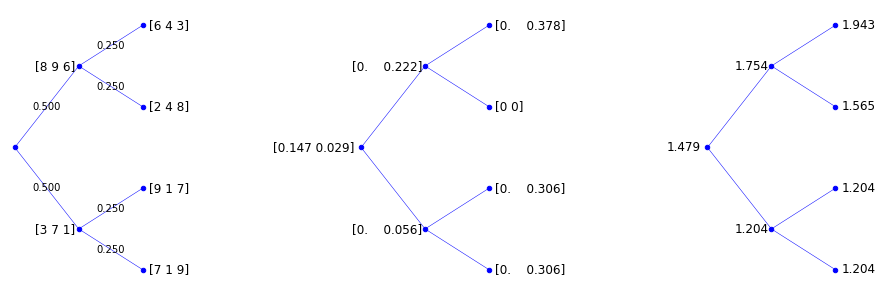

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=5, figsize=(15, 5))
solution.scenario_tree.plot_scenarios('d', ax=axes[0])
axes[1].axis('off')
solution.scenario_tree.plot(lambda node: np.round(node.data['decision'].get('x'), 3), ax=axes[2])
axes[3].axis('off')
solution.scenario_tree.plot(lambda node: np.round(node.data['v'], 3), ax=axes[4])